<a href="https://colab.research.google.com/github/jenferon/Machine_Learning_Practise/blob/main/ML_course_project/classifying_lego_minifigures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Lego Minifigures

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all the libraries needed

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from fastai.vision.all import *
from fastai.metrics import error_rate
import kagglehub
import torch
from fastai.vision.augment import aug_transforms


In [ ]:
#bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [ ]:
base = 'gdrive/MyDrive/MPAGS_ML_Project/archive/' #change this with where the data is

Define classes for formatting the data

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        paths,
        targets,
        image_size=(224, 224),
        batch_size=64,
        shuffle=True,
        transforms=None
    ):
        # the list of paths to files
        self.paths = paths
        # the list with the true labels of each file
        self.targets = targets
        # images size
        self.image_size = image_size
        # batch size (the number of images)
        self.batch_size = batch_size
        # if we need to shuffle order of files
        # for validation we don't need to shuffle, for training - do
        self.shuffle = shuffle
        # Augmentations for our images. It is implemented with albumentations library
        self.transforms = transforms

        # Call function to create and shuffle (if needed) indices of files
        self.on_epoch_end()

    def on_epoch_end(self):
        # This function is called at the end of each epoch while training

        # Create as many indices as many files we have
        self.indexes = np.arange(len(self.paths))
        # Shuffle them if needed
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        # We need that this function returns the number of steps in one epoch

        # How many batches we have
        return len(self.paths) // self.batch_size


    def __getitem__(self, index):
        # This function returns batch of pictures with their labels

        # Take in order as many indices as our batch size is
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Take image file paths that are included in that batch
        batch_paths = [self.paths[k] for k in indexes]

        # Take labels for each image
        batch_y = [self.targets[k] - 1 for k in indexes]
        batch_X = []
        for i in range(self.batch_size):
            # Read the image
            img = cv2.imread(batch_paths[i])
            # Resize it to needed shape
            img = cv2.resize(img, self.image_size)
            # Convert image colors from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Normalize image
            img = img / 255.
            # Apply transforms (see albumentations library)
            if self.transforms:
                img = self.transforms(image=img)['image']

            batch_X.append(img)

        return np.array(batch_X), np.array(batch_y)

I am using data from Kaggle

In [ ]:
# Download latest version
BASE_DIR = kagglehub.dataset_download("ihelon/lego-minifigures-classification")

print("Path to dataset files:", BASE_DIR)

Path to dataset files: /root/.cache/kagglehub/datasets/ihelon/lego-minifigures-classification/versions/30


I am using this data but there was a typo in one line of the metadata.csv file so I made a local copy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')  #can comment this line if not using google drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df_index = pd.read_csv(os.path.join(base, 'index.csv'), index_col=None)
df_metadata = pd.read_csv(os.path.join(base, 'metadata.csv'), index_col=None)
print(f"Columns in df_metadata: {df_metadata.columns}")
df_index = pd.merge(df_index, df_metadata[['class_id', 'minifigure_name']], on='class_id')

Columns in df_metadata: Index(['class_id', 'lego_ids', 'lego_names', 'minifigure_name'], dtype='object')


Look at the data to check the naming is working corretly

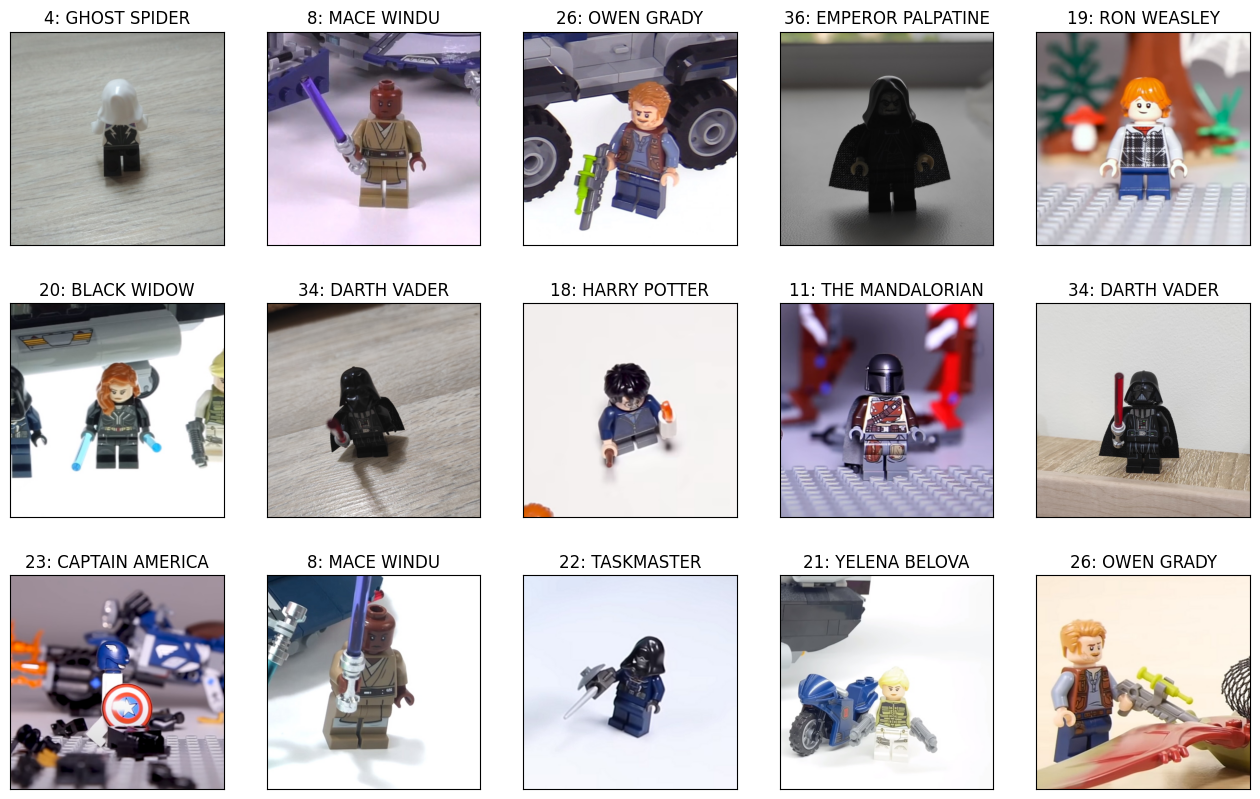

In [ ]:
plt.figure(figsize=(16, 10))
for ind, el in enumerate(df_index.sample(15).iterrows(), 1):
    plt.subplot(3, 5, ind)
    image = cv2.imread(os.path.join(BASE_DIR, el[1]['path']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"{el[1]['class_id']}: {el[1]['minifigure_name']}")
    plt.xticks([])
    plt.yticks([])

Look at one specific character

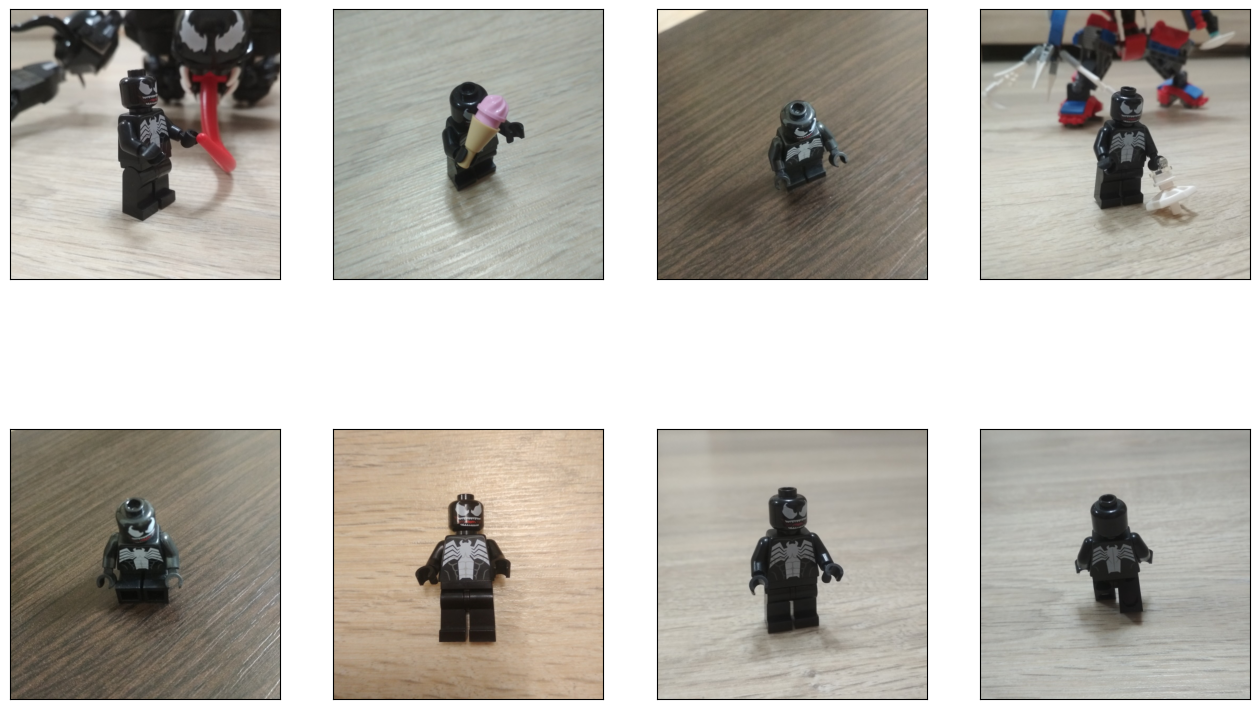

In [ ]:
plt.figure(figsize=(16, 10))
for ind, el in enumerate(df_index[df_index['minifigure_name']=='VENOM'].sample(8).iterrows(), 1):
    plt.subplot(2, 4, ind)
    image = cv2.imread(os.path.join(BASE_DIR, el[1]['path']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

Split the data into training and validation sets

In [ ]:
df_index['train-valid'] = pd.Series(train_test_split(df_index.index, test_size=0.2, random_state=42)[0]).apply(lambda x: 'train' if x else 'valid').reindex(df_index.index, fill_value='valid')

# Get only train rows
tmp_train = df_index[df_index['train-valid'] == 'train']
# Get train file paths
train_paths = tmp_train['path'].values
# Get train labels
train_targets = tmp_train['class_id'].values
# Create full train paths (base dir + concrete file)
train_paths = list(map(lambda x: os.path.join(BASE_DIR, x), train_paths))

# Get only valid rows
tmp_valid = df_index[df_index['train-valid'] == 'valid']
# Get valid file paths
valid_paths = tmp_valid['path'].values
# Get valid labels
valid_targets = tmp_valid['class_id'].values
# Create full valid paths (base dir + concrete file)
valid_paths = list(map(lambda x: os.path.join(BASE_DIR, x), valid_paths))

Look at the amount it has put into training and validation to check

In [ ]:
df_index.minifigure_name, len(df_index.class_id), len(tmp_train), len(tmp_valid)

(0      SPIDER-MAN
 1      SPIDER-MAN
 2      SPIDER-MAN
 3      SPIDER-MAN
 4      SPIDER-MAN
           ...    
 366     BOBA FETT
 367     BOBA FETT
 368     BOBA FETT
 369     BOBA FETT
 370     BOBA FETT
 Name: minifigure_name, Length: 371, dtype: object,
 371,
 296,
 75)

Now train the data on a CNN for image recognition

In [ ]:
# Create DataLoaders object from your DataFrame
dls = ImageDataLoaders.from_df(df_index, # Your DataFrame
                               path=base, # Path to your image directory
                               label_col='minifigure_name', # Column name for labels
                               fn_col='path', # Column name for image file paths
                               valid_pct=0.2, # Percentage of data for validation
                               item_tfms=Resize(224), # Image transformations
                               batch_tfms=aug_transforms()) # Batch augmentations

# Now use dls in your cnn_learner (or vision_learner) function
learn = cnn_learner(dls, models.resnet50, metrics=error_rate)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [ ]:
learn.model;

Number of cycles and learning rate has been tweaked to produce a fast and well trained model

In [ ]:
learn.fit_one_cycle(5, lr_max=0.001737800776027143)

In [ ]:
#save the first itteration of the model
learn.save('minifigures-stage-1')

Path('gdrive/MyDrive/MPAGS_ML_Project/archive/models/minifigures-stage-1.pth')

In [ ]:
loaded_learn = load_learner(base+'models/minifigures-stage-1.pth', cpu=False)


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(learn.dls.valid)==len(losses)==len(idxs)

False

Plot the images that have the highest loss

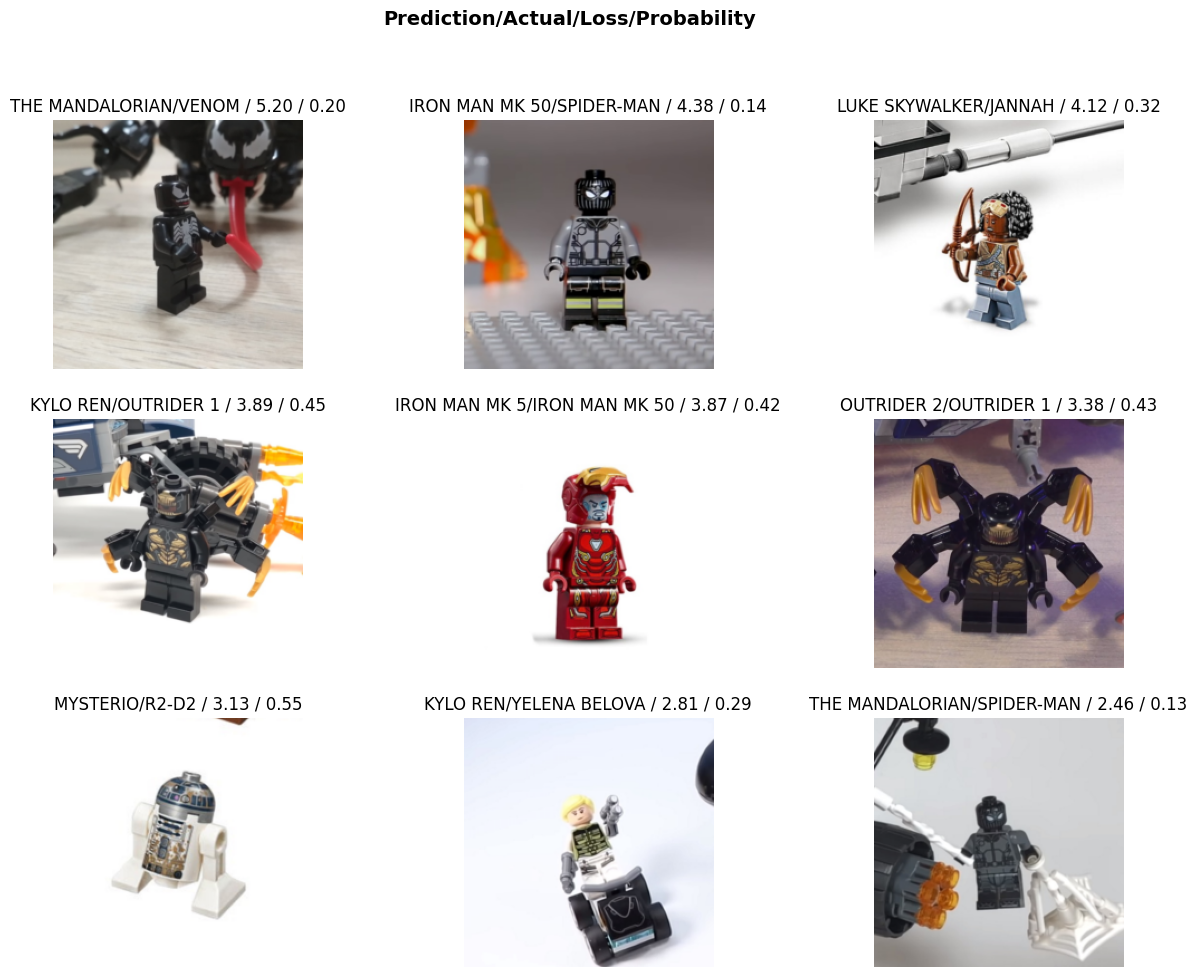

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

Plot the confusion matrix to see where the confusion arises

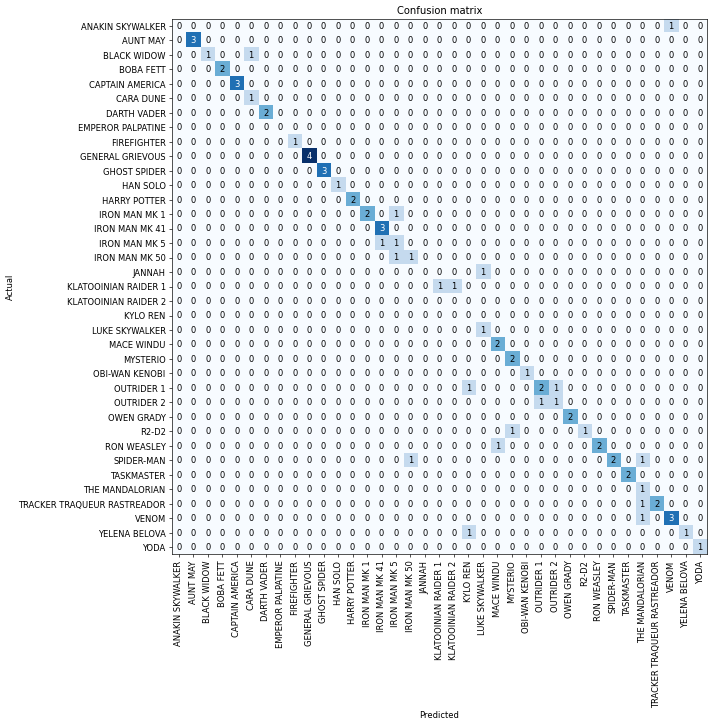

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[]

Plot to find the optimum learning rate

SuggestedLRs(valley=0.0020892962347716093)

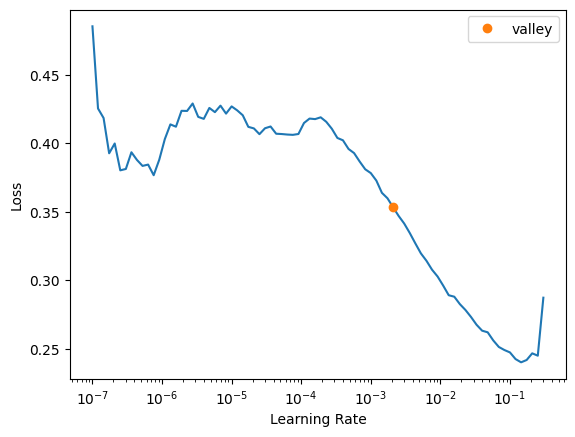

In [ ]:
learn.lr_find()

A good first try, so now try again after unfreezing the first layers to see if we see an improvement

In [ ]:
learn.unfreeze()

Use a variable learning rate for different layers to speed up code

In [ ]:
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-4))

SuggestedLRs(valley=0.0002290867705596611)

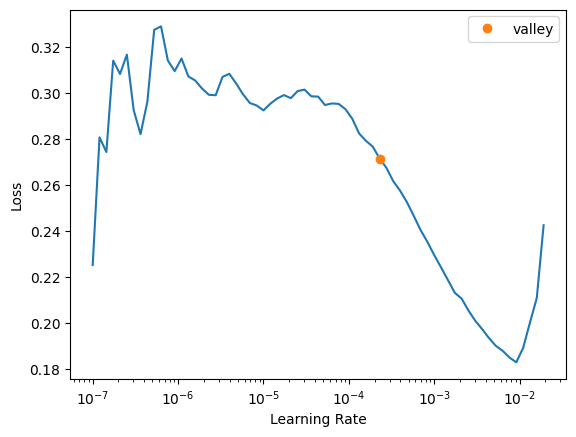

In [ ]:
learn.lr_find()

In [ ]:
#save the second itteration of the model
learn.save('minifigures-stage-2_unfreeze')

Path('gdrive/MyDrive/MPAGS_ML_Project/archive/models/minifigures-stage-2_unfreeze.pth')

In [ ]:
loaded_learn = load_learner(base+'models/minifigures-stage-2_unfreeze.pth', cpu=False)
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(learn.dls.valid)==len(losses)==len(idxs)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


False

Look to see if the confusion matrix has improved

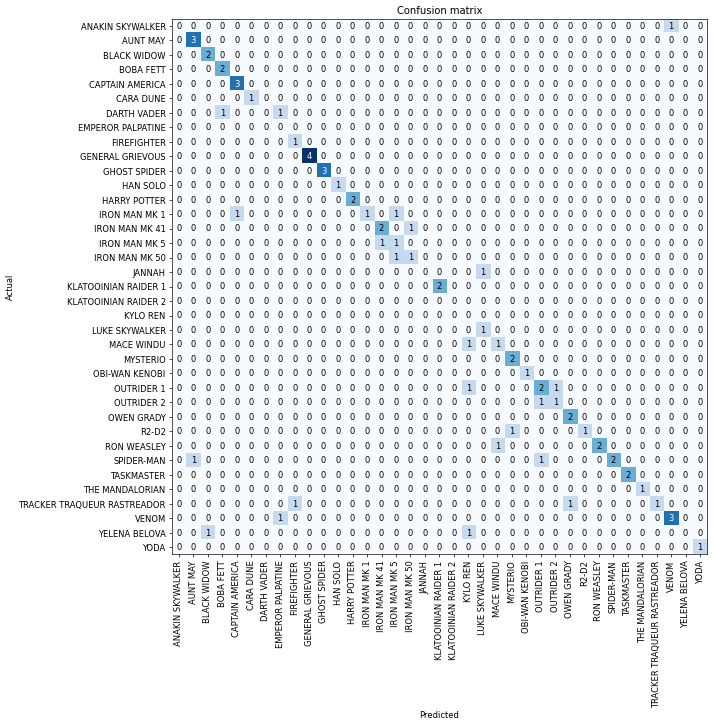

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Try with data augmentation so I have more data to learn with



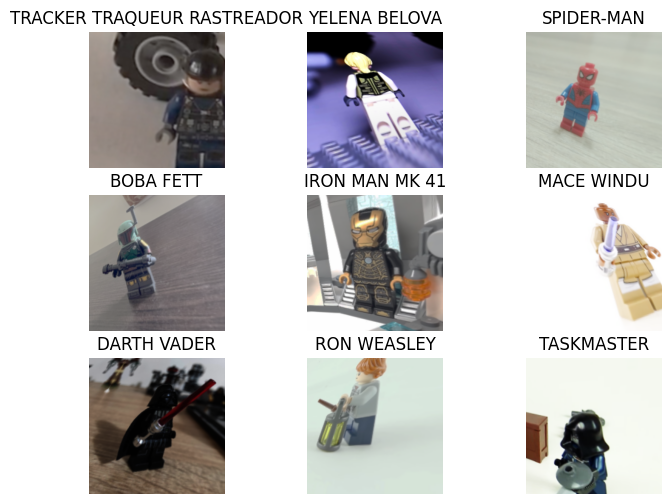

In [ ]:
tfms = aug_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

dls = ImageDataLoaders.from_df(df_index,
                               path=BASE_DIR,
                               label_col='minifigure_name',
                               fn_col='path',
                               valid_pct=0.2,
                               item_tfms=Resize(224),  # Keep only Resize
                               batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)])  # Apply augmentations in batch_tfms

#show images that have been augmented
dls.show_batch(max_n=9, figsize=(8,6))


In [ ]:
#relearn on augmented and non augmented data
learn = vision_learner(dls, models.resnet50, metrics=error_rate)

In [ ]:
learn.model;

In [ ]:
learn.fit_one_cycle(8, lr_max=0.002511886414140463)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(learn.dls.valid)==len(losses)==len(idxs)

False

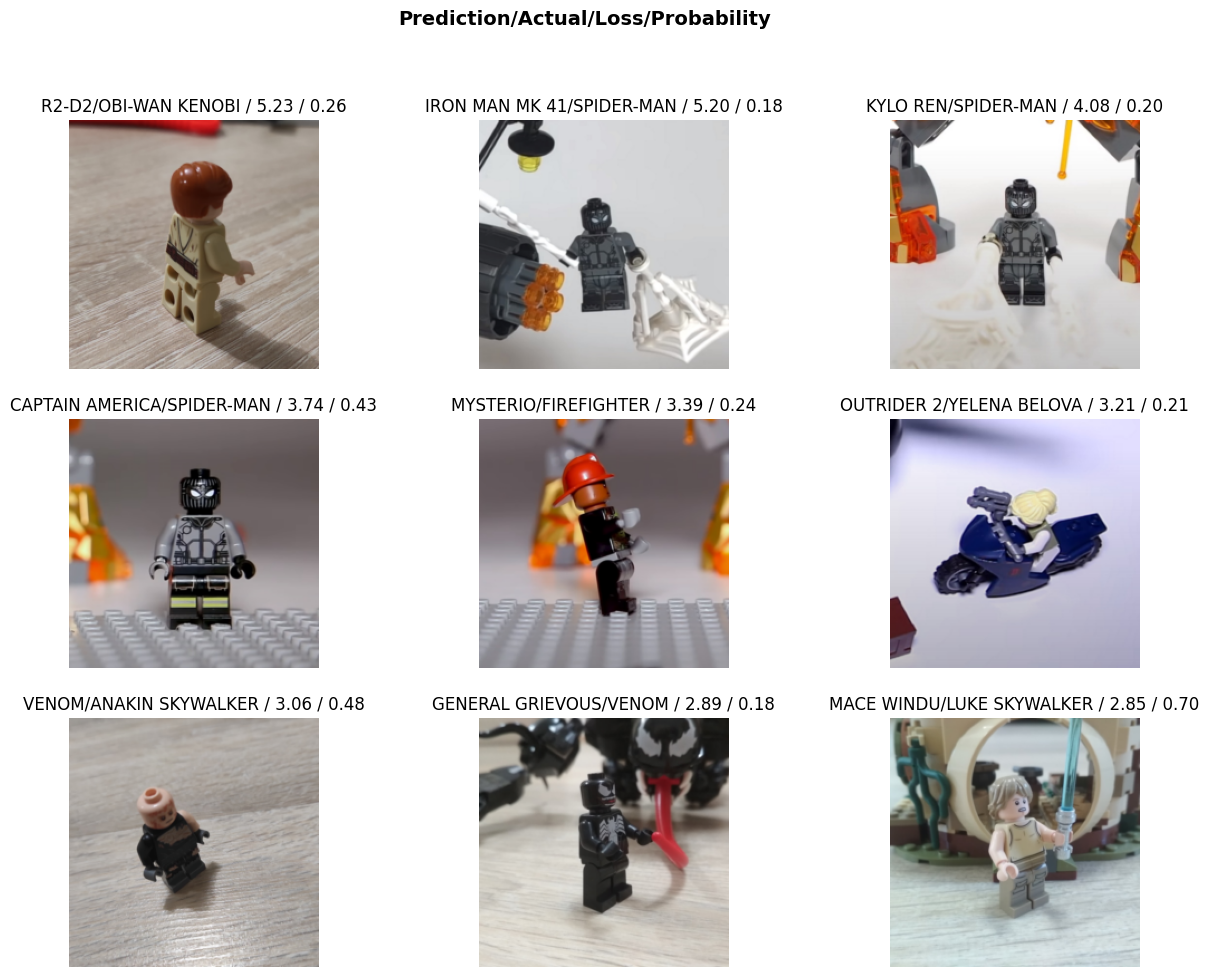

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

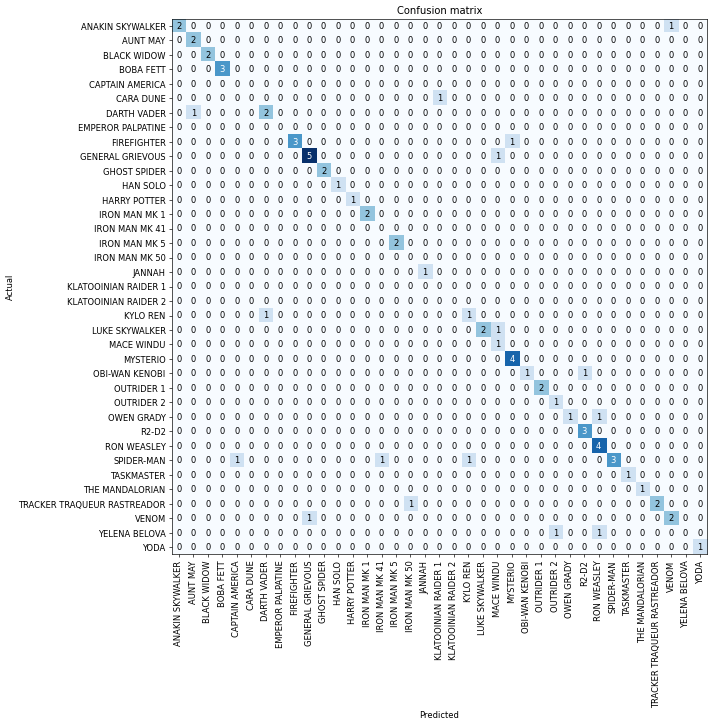

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[]

SuggestedLRs(valley=0.0030199517495930195)

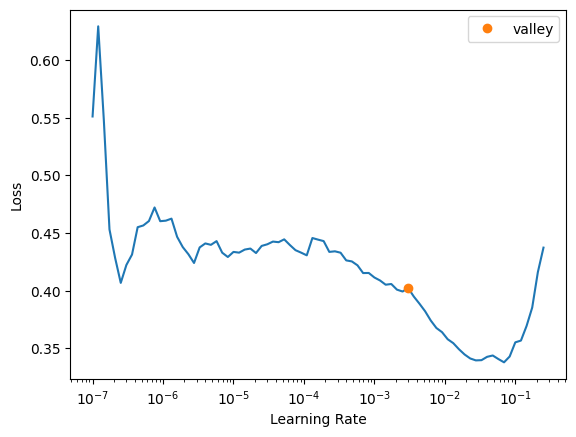

In [ ]:
learn.lr_find()

In [ ]:
#save the second itteration of the model
learn.save('minifigures-stage-3_data_aug')
loaded_learn = load_learner(base+'models/minifigures-stage-3_data_aug.pth', cpu=False)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


FileNotFoundError: [Errno 2] No such file or directory: 'gdrive/MyDrive/MPAGS_ML_Project/archive/models/minifigures-stage-3_data_aug.pth'

Again try with using data augmentation and unfreezing the first layers using a variable learning rate

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-6,1e-4))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(learn.dls.valid)==len(losses)==len(idxs)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
#save the second itteration of the model
learn.save('minifigures-stage-4_data_aug_unfreeze')
loaded_learn = load_learner(base+'models/minifigures-stage-4_data_aug_unfreeze.pth', cpu=False)